In [834]:
from pprint import pprint
import pandas as pd
import numpy as np
from utils.common import create_logger, get_dataset, predict_from_env, predict_from_frame, running_mean_last_n_samples, VecEnvMonitor
import seaborn as sns
import matplotlib.pyplot as plt
from utils.constants import client_subset

In [826]:
fpath = "../data/model/pop_fixed_dataset.csv"
df = get_dataset(fpath)


In [827]:
usecols = ['misspayment_days',
'date_code',
'misspayment_days_90d_12m',
'total_balance',
'client_id',
'income',
'age',
'mortgage',
'mortgage_qty',
'maturity_months',
'monthly_payment',
'subsidy',
'interest_rate_fixed',
'default_120_12m']

rename = {
          'misspayment_days': 'mispay_days',
          'misspayment_days_90d_12m':'mispay_d_90d_12m',

          }

In [828]:
df= df[usecols].rename(columns=rename)

In [829]:
CUTOFF = 20 # out of time set
train = df[df["date_code"] <= CUTOFF].copy()
test = df[df["date_code"] > CUTOFF].copy()

In [830]:
train_subset = train[train.client_id.isin(client_subset)]

<Axes: xlabel='date_code'>

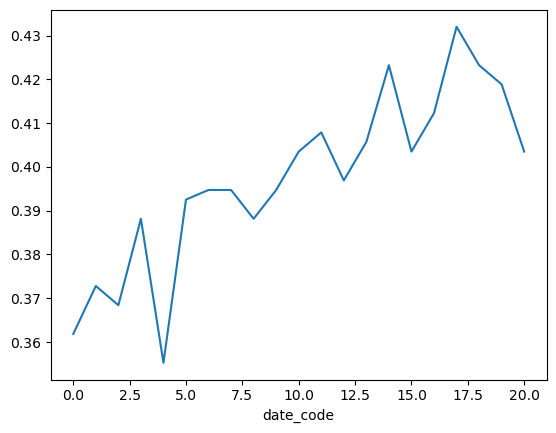

In [831]:
train_subset.groupby('date_code')['default_120_12m'].mean().plot()

In [832]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train_subset.describe(include="all").T.round(20)

,count,mean,std,min,25%,50%,75%,max
mispay_days,9576.00,75.57,171.70,0.00,0.00,0.00,43.00,1697.00
date_code,9576.00,10.00,6.06,0.00,5.00,10.00,15.00,20.00
mispay_d_90d_12m,9576.00,164.24,246.22,0.00,10.00,63.00,180.00,1697.00
total_balance,9576.00,63594.27,72178.16,2304.56,29658.43,44200.85,69661.19,662962.81
client_id,9576.00,12902.24,7235.38,35.00,7000.25,13352.50,19092.75,24857.00
income,9576.00,891.73,223.71,711.77,784.01,837.88,915.17,3228.34
age,9576.00,43.84,11.19,24.00,35.00,42.00,53.00,90.00
mortgage,9576.00,76465.74,78236.02,13527.87,39906.40,56700.00,78302.00,713000.00
mortgage_qty,9576.00,1.05,0.22,1.00,1.00,1.00,1.00,2.00
maturity_months,9576.00,354.63,55.62,180.00,360.00,360.00,374.00,722.00


In [837]:
ALIASES = True
if ALIASES:
    col_legibility_mapping = dict(zip(train_subset.columns.tolist(), list(f"x_{x+1}" for x in (range(len(train_subset.columns.tolist()))))))
    train_subset_alias = train_subset.rename(columns=col_legibility_mapping)
    pprint(col_legibility_mapping,sort_dicts=False)

{'mispay_days': 'x_1',
 'date_code': 'x_2',
 'mispay_d_90d_12m': 'x_3',
 'total_balance': 'x_4',
 'client_id': 'x_5',
 'income': 'x_6',
 'age': 'x_7',
 'mortgage': 'x_8',
 'mortgage_qty': 'x_9',
 'maturity_months': 'x_10',
 'monthly_payment': 'x_11',
 'subsidy': 'x_12',
 'interest_rate_fixed': 'x_13',
 'default_120_12m': 'x_14'}


In [972]:

# Open the file in write mode
with open('../model/utils/constants.py', 'w') as file:
    # Write the content of the first variable to the file
    file.write("client_subset = {}\n".format(client_subset))
    # Write the content of the second variable to the file on a new line
    file.write("col_legibility_mapping = {}".format(col_legibility_mapping))


In [841]:
res = []
for month in train_subset.date_code.unique():
    numcols = train_subset[train_subset.date_code==month].drop(["date_code",'client_id'], axis=1)
    numcols = numcols.rename(columns=col_legibility_mapping)
    corr = numcols.corr(method='pearson').values
    res.append(corr)
npres = np.stack(res)

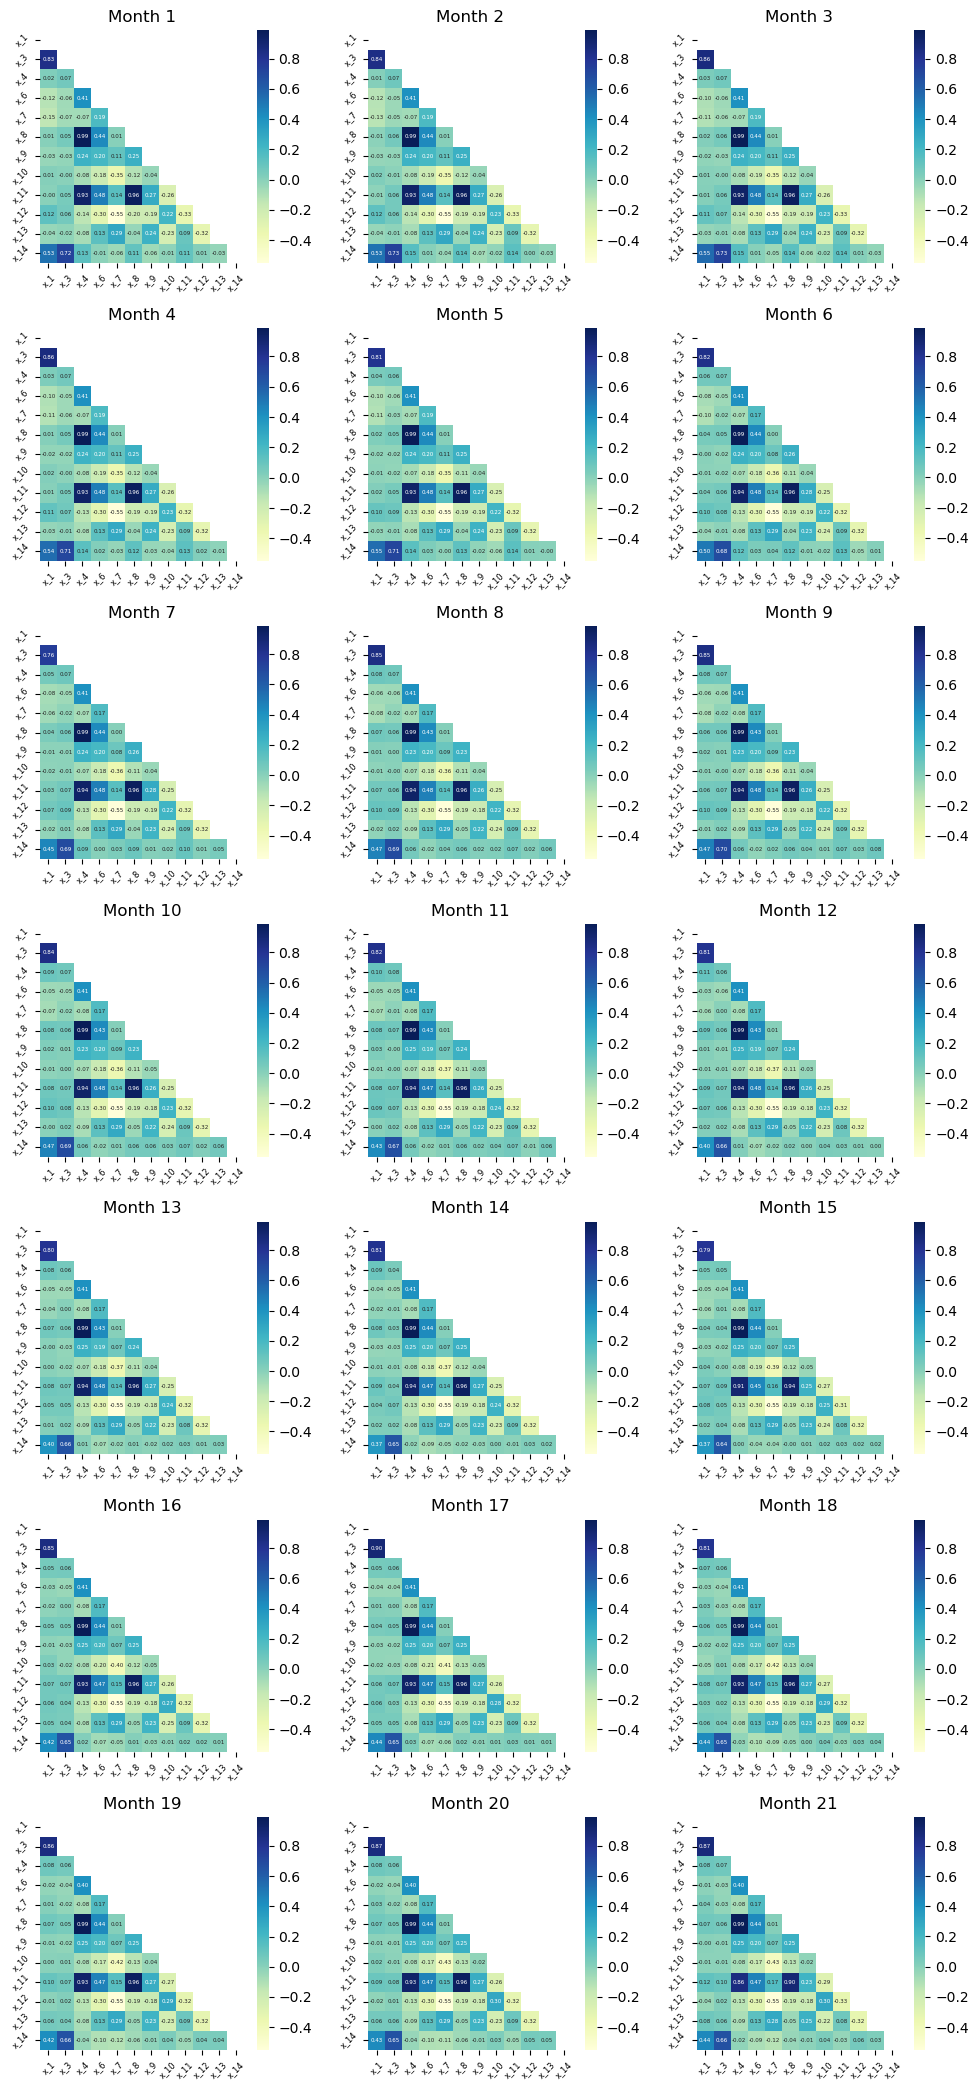

In [966]:
num_months = npres.shape[0]
num_cols = 3
num_rows = int(np.ceil(num_months / num_cols))

plt.figure(figsize=(10, 3 * num_rows))
mask = np.triu(np.ones_like(npres[0], dtype=bool))
for i in range(num_months):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    sns.heatmap(pd.DataFrame(npres[i], columns=numcols.columns, index=numcols.columns), annot=True, fmt="1.2f", cmap='YlGnBu', mask=mask,  annot_kws={"size": 4})
    plt.title(f"Month {i + 1}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()
plt.show()


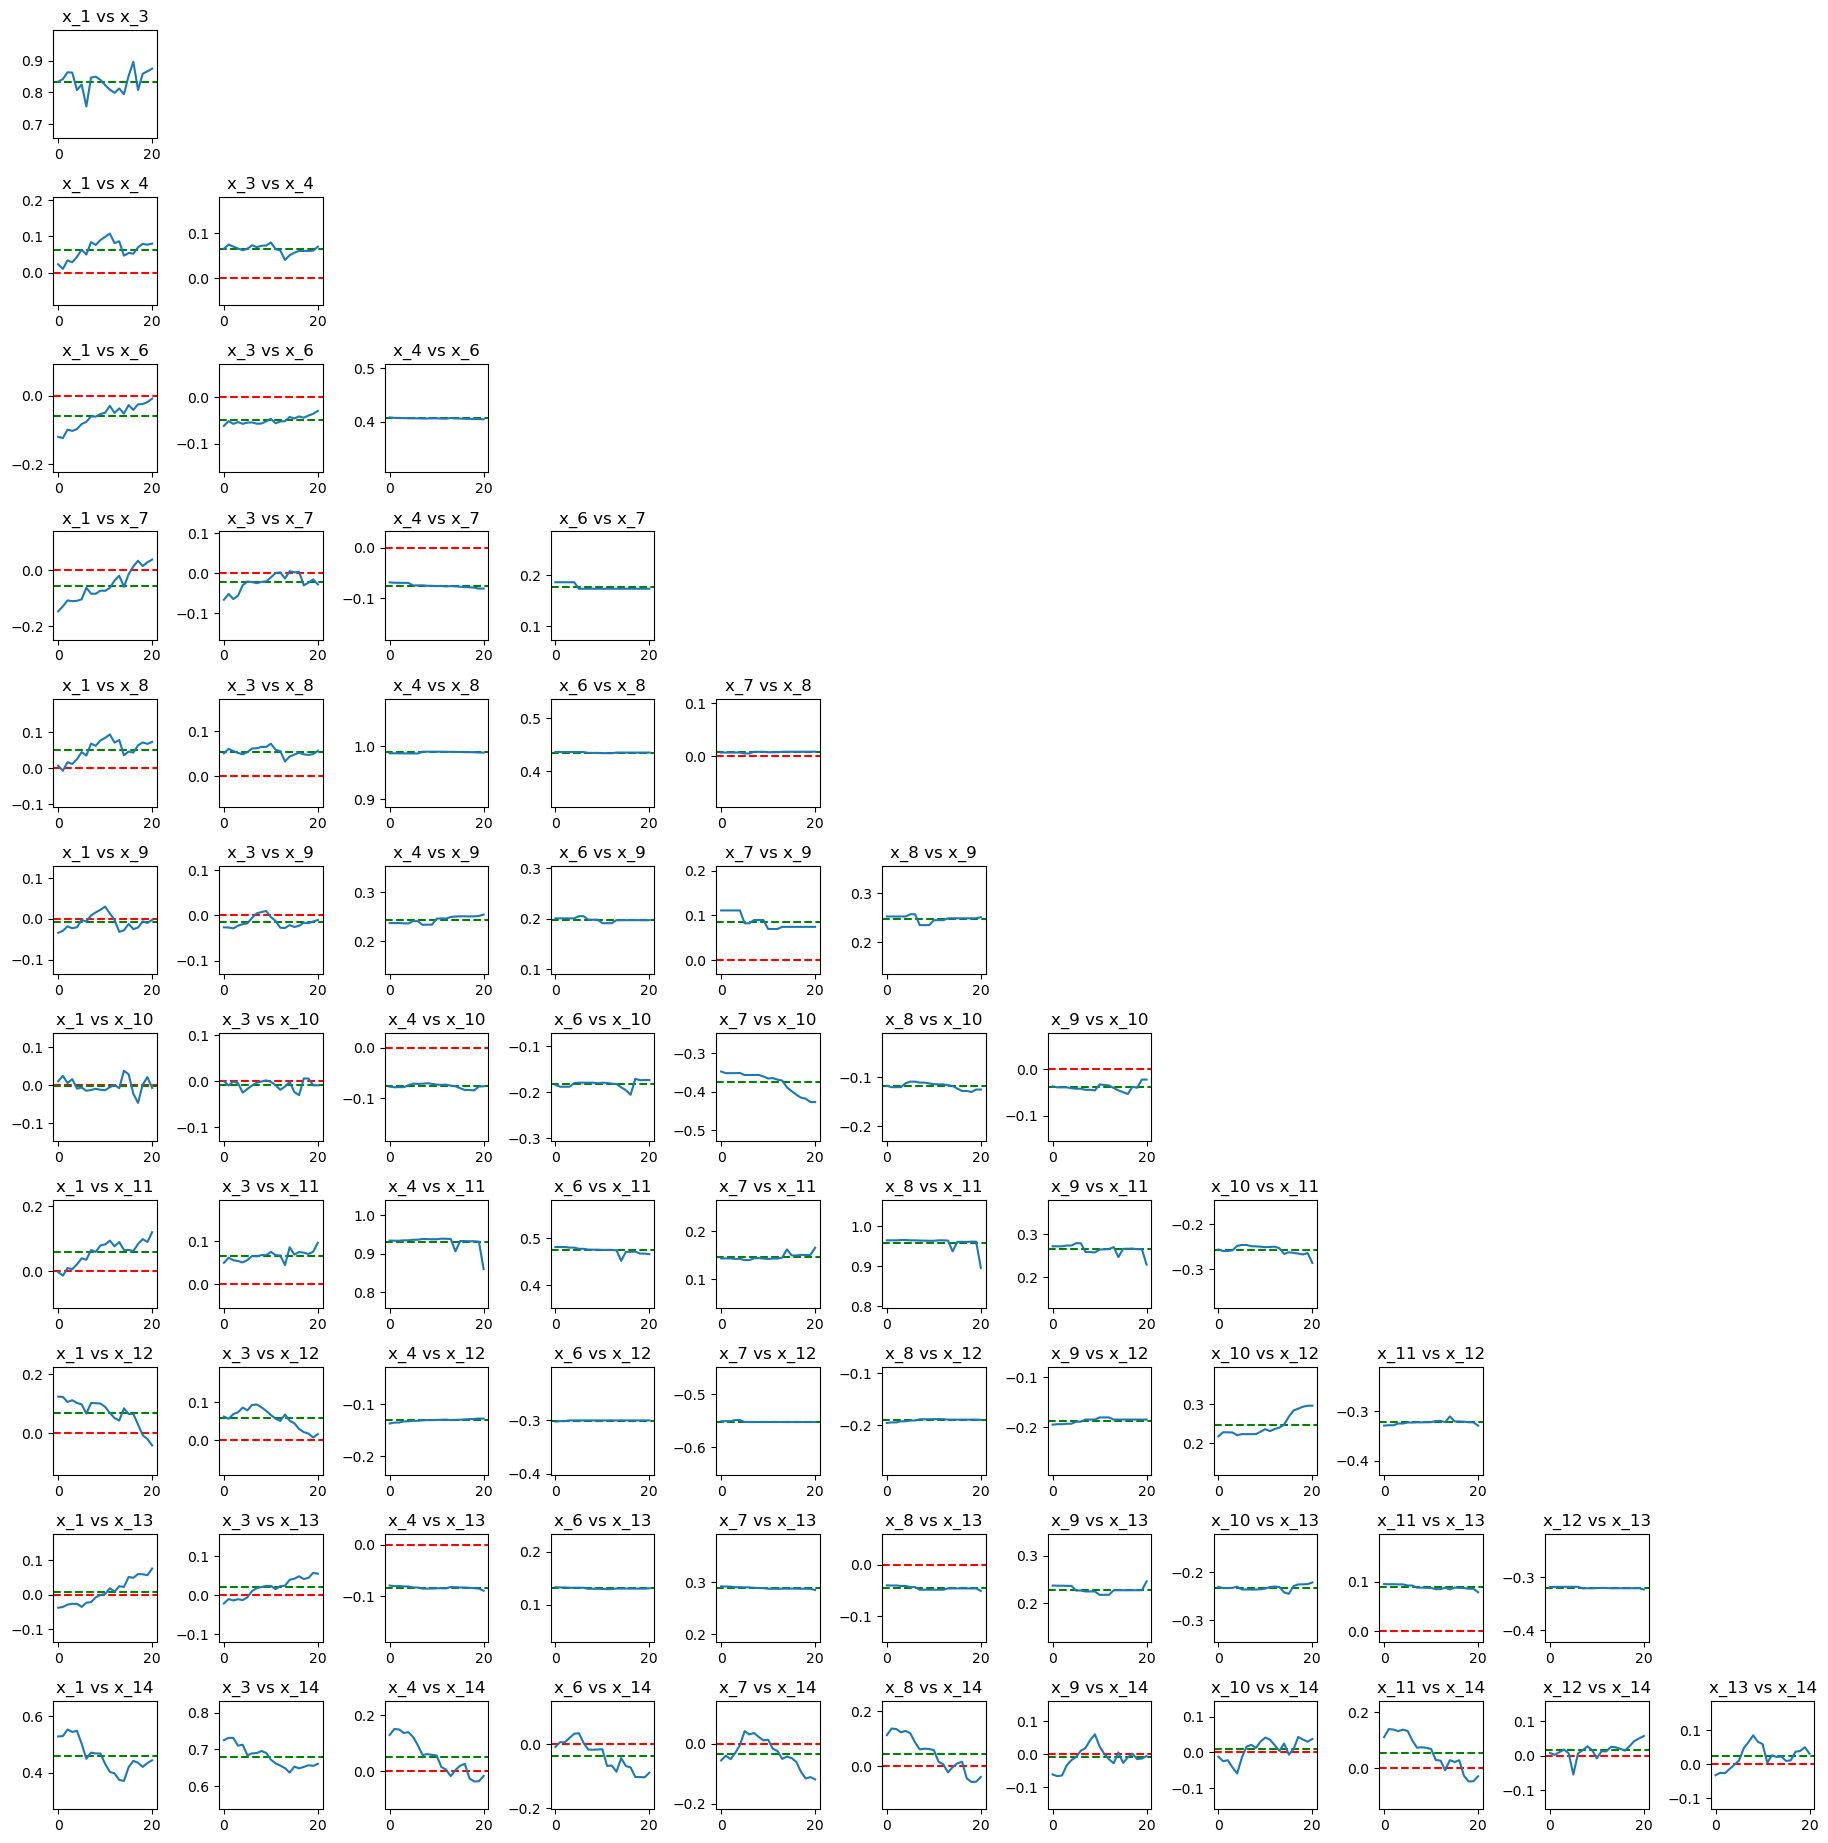

In [974]:
features = numcols.columns.tolist()
num_features = len(features)
months = train_subset.date_code.unique()

# Prepare the figure
plt.figure(figsize=(20, 20))  # Adjust the size as needed
for i in range(num_features):
    for j in range(num_features):
        # Plot only for lower triangular and non-diagonal elements
        if i > j:
            plt.subplot(num_features, num_features, i * num_features + j + 1)
            
            # Extract the time series of the correlation for this pair of features
            time_series = npres[:, i, j]
            plt.axhline(y=0, color='r', linestyle='--')
            plt.axhline(y=np.mean(time_series), color='green', linestyle='--')
            plt.plot(months, time_series)
            # Use feature names for titles
            plt.title(f'{features[j]} vs {features[i]}')
            plt.ylim(min(time_series)-0.1, max(time_series)+0.1)  # Correlation values range from -1 to 1
plt.tight_layout()
plt.show()